<a href="https://colab.research.google.com/github/siliconshells/Explainable-AI/blob/main/machine_learning_court.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# 👩‍⚖️ ⚖️ Machine Learning Court

This notebook provides base model training code for our three case scenarios:
1. **Loan Approval**
2. **Breast Cancer Misclassification**
3. **Recidivism Prediction**

> ⚠️ This notebook does **not** include XAI techniques (SHAP, LIME, Anchors). You are expected to implement those yourself based on the model and prediction tasks below.





## 🩺 Case 2: Tumor Misclassification – Breast Cancer Dataset
#### 🔍 Scenario
Patient X received a benign classification from an AI tumor diagnostic tool and was not referred for a biopsy. Months later, the tumor was diagnosed as malignant. The model’s output is now under scrutiny.

#### 🟦 Defense
Defend the decision with reference to the model’s logic and learned feature importance. Consider how this decision aligns with the broader data trends.

In [ ]:
# 🧬 Case 2: Tumor Misclassification (Breast Cancer Dataset)
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shap
import warnings

shap.initjs()

warnings.filterwarnings("ignore", message="X does not have valid feature names")

# Load dataset
data = load_breast_cancer()
df_bc = pd.DataFrame(data.data, columns=data.feature_names)
df_bc["target"] = data.target  # 0 = malignant, 1 = benign

# Train/test split
X = df_bc.drop("target", axis=1)
y = df_bc["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model_bc = RandomForestClassifier(random_state=42)
model_bc.fit(X_train, y_train)
print(classification_report(y_test, model_bc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



## 1. Exploratory Data Analysis (EDA)

In [ ]:
print(f"Data size: {X.shape}, Train size: {X_train.shape}, Test size: {X_test.shape}")
X.head()

Data size: (569, 30), Train size: (455, 30), Test size: (114, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# Finding null values in the dataset
df_bc.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

In [ ]:
# Shape of the dataset
print(f"There are {df_bc.shape[0]} rows and {df_bc.shape[1]} columns in the dataset.")

# Summary statistics
df_bc.describe()

There are 569 rows and 31 columns in the dataset.


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


worst area              0.153892
worst concave points    0.144663
mean concave points     0.106210
worst radius            0.077987
mean concavity          0.068001
worst perimeter         0.067115
mean perimeter          0.053270
mean radius             0.048703
mean area               0.047555
worst concavity         0.031802
area error              0.022407
worst texture           0.021749
worst compactness       0.020266
radius error            0.020139
mean compactness        0.013944
mean texture            0.013591
perimeter error         0.011303
worst smoothness        0.010644
worst symmetry          0.010120
concavity error         0.009386
dtype: float64

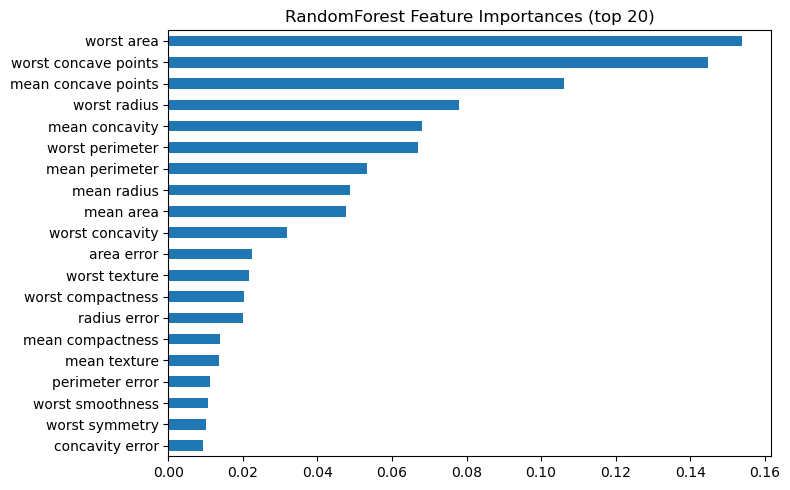

In [ ]:
# ---- Global: Randomforest feature importances ----
rf_importance = pd.Series(
    getattr(model_bc, "feature_importances_", None),
    index=getattr(
        X_train, "columns", range(len(getattr(model_bc, "feature_importances_", [])))
    ),
)
rf_importance = rf_importance.sort_values(ascending=False)
display(rf_importance.head(20))

plt.figure(figsize=(8, 5))
rf_importance.head(20).iloc[::-1].plot(kind="barh")
plt.title("RandomForest Feature Importances (top 20)")
plt.tight_layout()
plt.show()

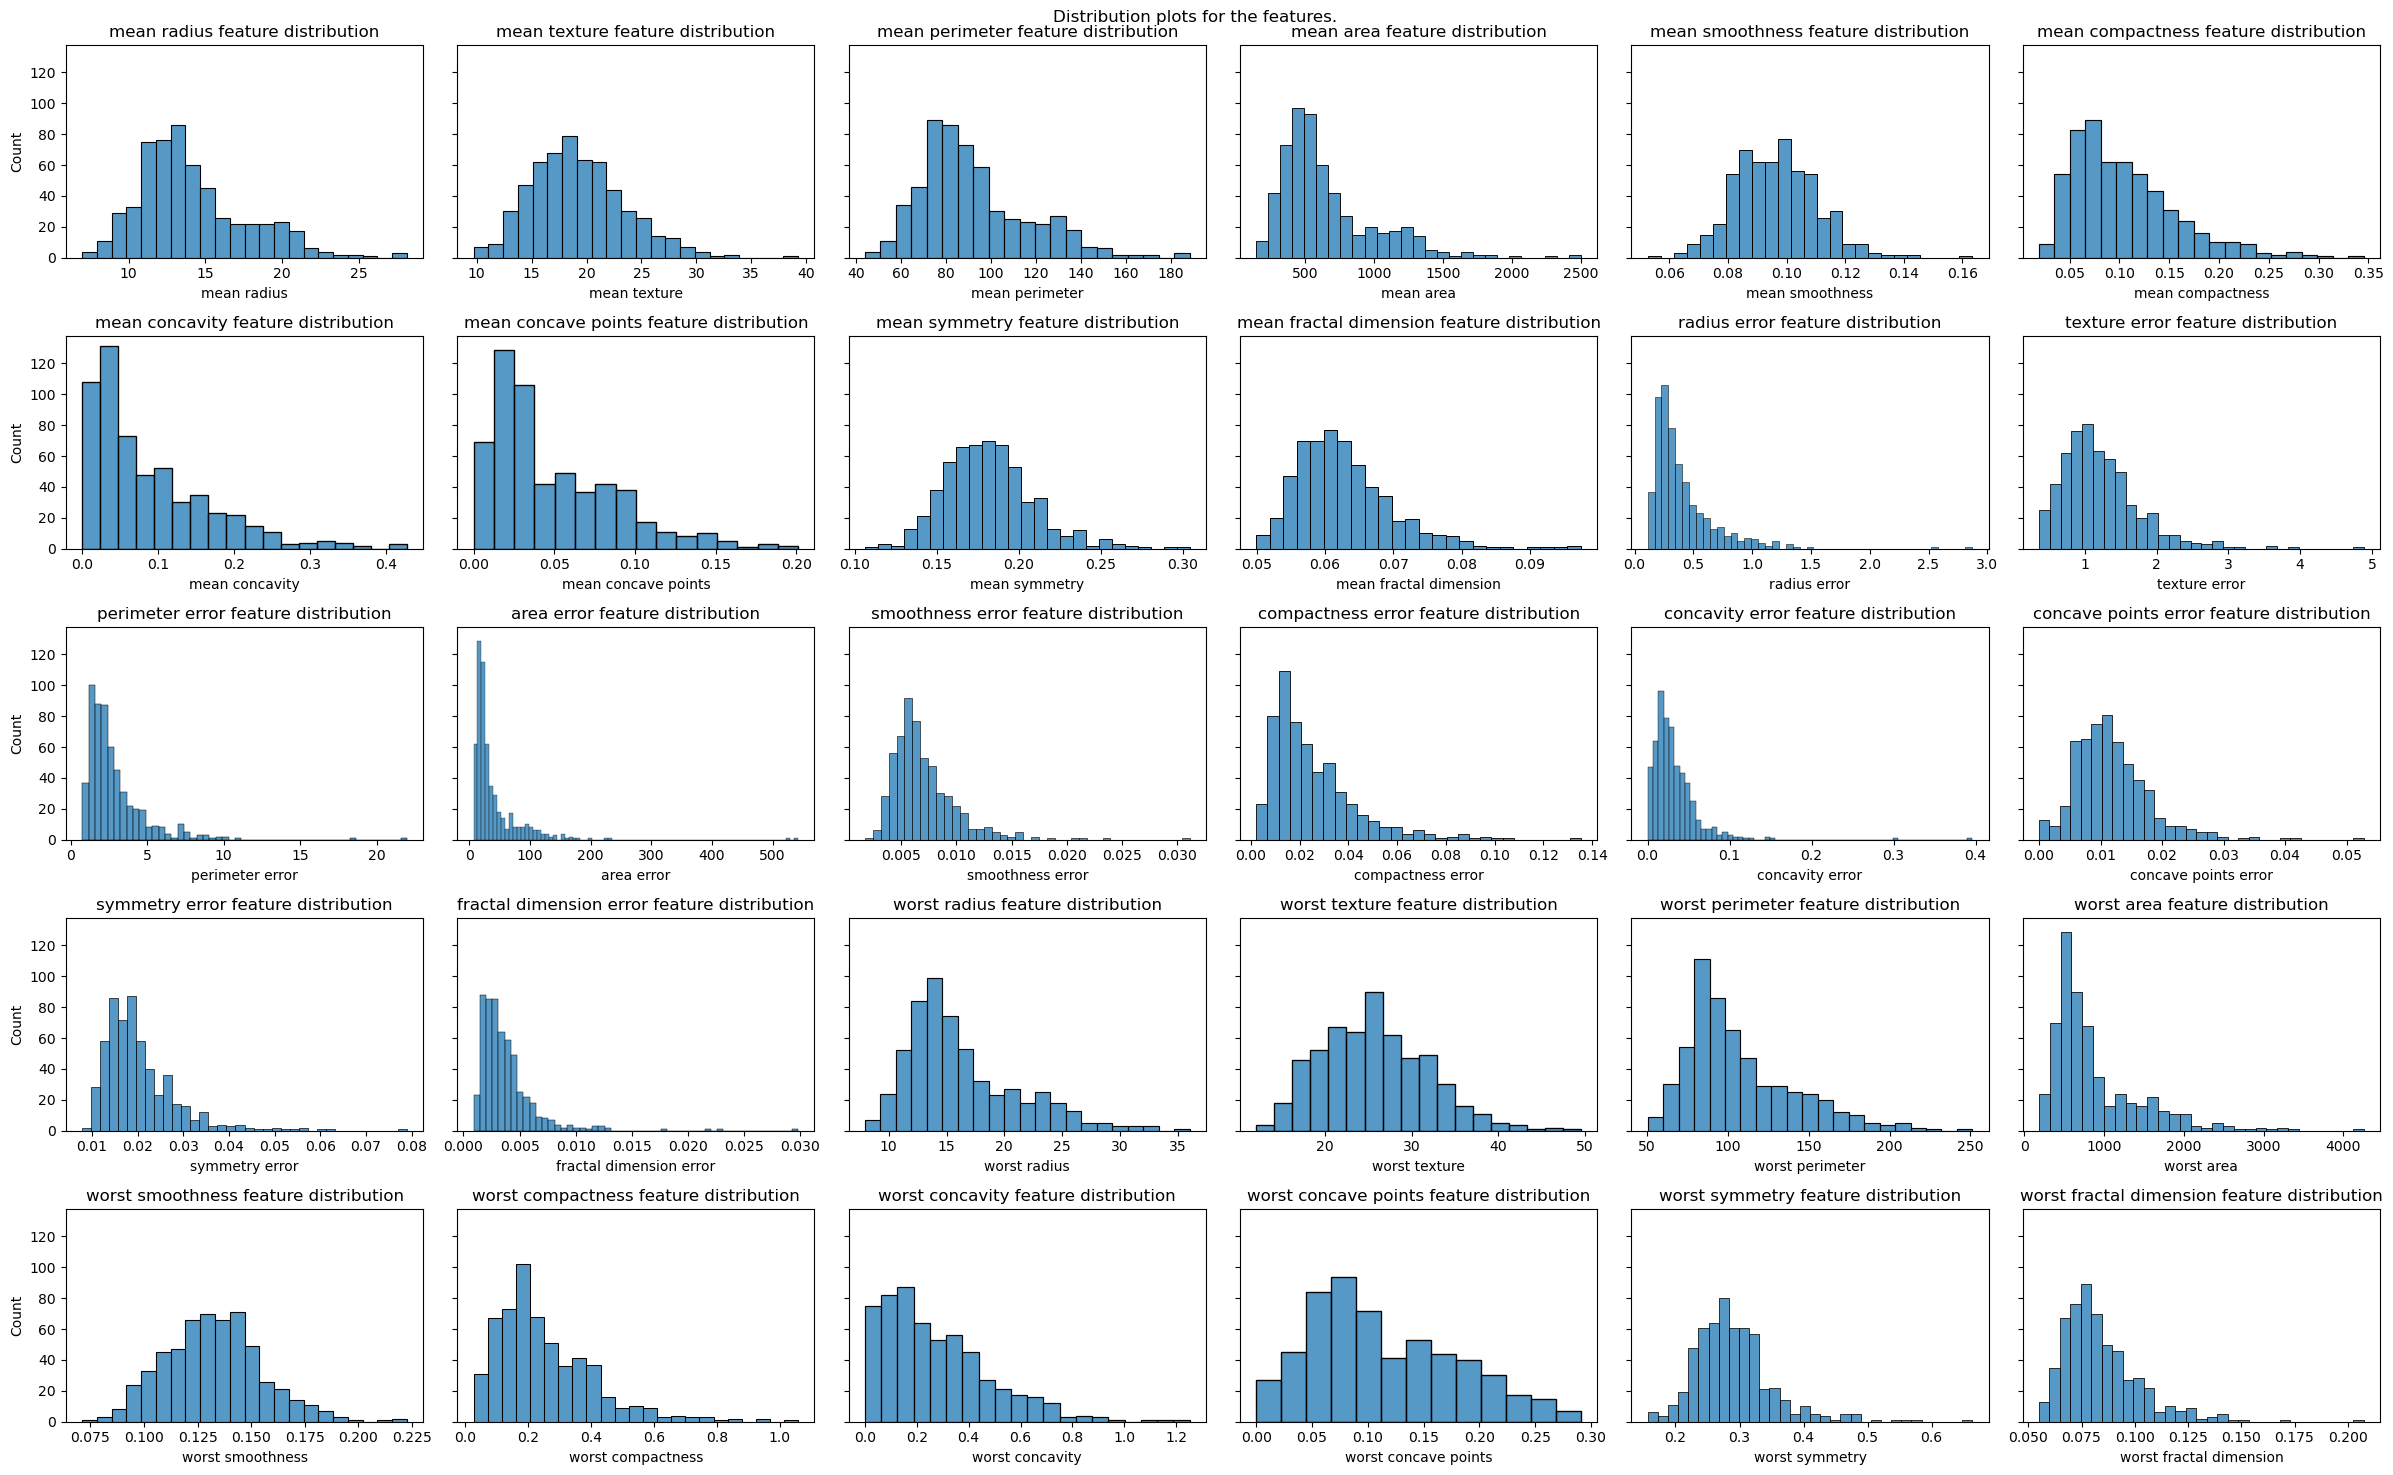

In [ ]:
def distribution_grid_seaborn(df, x_cols, rows=5, cols=6, suptitle=None):
    n = min(len(x_cols), rows * cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharey=True)
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i < n:
            x = x_cols[i]
            sns.histplot(data=df, x=df[x_cols[i]], ax=ax)
            ax.set_title(f"{x} feature distribution")
            if i % cols == 0:  # only leftmost plots get y-label
                ax.set_ylabel("Count")
            else:
                ax.set_ylabel("")
            ax.set_xlabel(x)
        else:
            ax.set_visible(False)

    if suptitle:
        fig.suptitle(suptitle, y=0.98)
    plt.tight_layout()
    plt.show()


distribution_grid_seaborn(
    X,
    model_bc.feature_names_in_,
    suptitle="Distribution plots for the features.",
)

## 2. The Prediction

In [ ]:
# 🧬 Focus Instance (Tumor Misclassification - Patient X)
focus_instance_bc = pd.DataFrame(
    [
        {
            "mean radius": 13.80,
            "mean texture": 15.79,
            "mean perimeter": 90.43,
            "mean area": 584.1,
            "mean smoothness": 0.1007,
            "mean compactness": 0.1280,
            "mean concavity": 0.07789,
            "mean concave points": 0.05069,
            "mean symmetry": 0.1662,
            "mean fractal dimension": 0.06566,
            "radius error": 0.4101,
            "texture error": 1.074,
            "perimeter error": 2.635,
            "area error": 40.14,
            "smoothness error": 0.00541,
            "compactness error": 0.02204,
            "concavity error": 0.01664,
            "concave points error": 0.01185,
            "symmetry error": 0.02095,
            "fractal dimension error": 0.004902,
            "worst radius": 16.57,
            "worst texture": 20.86,
            "worst perimeter": 110.3,
            "worst area": 812.4,
            "worst smoothness": 0.1411,
            "worst compactness": 0.3542,
            "worst concavity": 0.2779,
            "worst concave points": 0.1383,
            "worst symmetry": 0.2589,
            "worst fractal dimension": 0.1030,
        }
    ]
)

# Run prediction
pred = model_bc.predict_proba(focus_instance_bc)
print("Predicted probabilities (malignant, benign):", pred[0])
pred = model_bc.predict(focus_instance_bc)
print(
    "Prediction for Patient X:",
    "Benign → No Biopsy" if pred[0] == 1 else "Malignant → Action Needed",
)

Predicted probabilities (malignant, benign): [0.15 0.85]
Prediction for Patient X: Benign → No Biopsy


## 3. SHAP Explanations

In [ ]:
# Create the explainer
explainer = shap.TreeExplainer(model_bc)

# Compute SHAP values for the test set
shap_values = explainer(X_train)
shap_values.shape

(455, 30, 2)

### 3.1 SHAP for the Focus Instance (Patient X)

Explanation shape: (30,)
Base value: 0.6320659340659341
Top 5 feature contributions:
  worst texture: 0.04707635041504806
  mean concavity: 0.03587253975206612
  worst area: 0.033789714995057875
  worst radius: 0.02878264825393153
  mean perimeter: 0.018261629422578696
Waterfall Plot


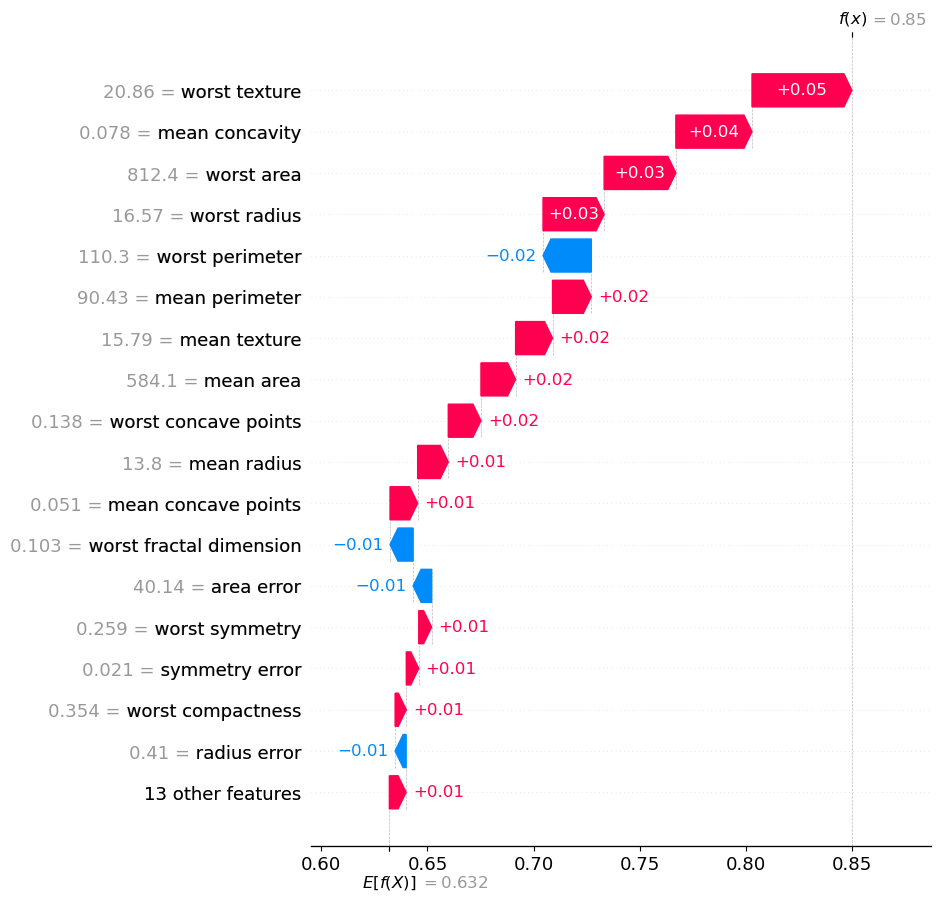

Bar Plot


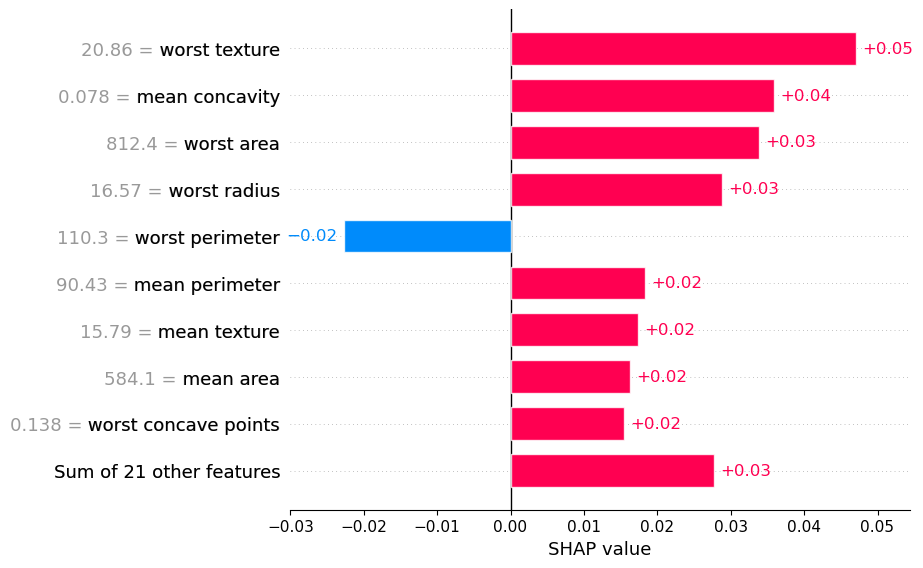

In [ ]:
# Generate SHAP values for the predicted focus instance
shap_values = explainer(focus_instance_bc)

# Extract explanation for the focus instance, benign class (index 1)
explanation = shap.Explanation(
    values=shap_values.values[0, :, 1],  # SHAP values for focus instance
    base_values=explainer.expected_value[1],  # Base value for benign class
    data=focus_instance_bc.iloc[0].values,  # Feature values for the focus instance
    feature_names=focus_instance_bc.columns.tolist(),  # Feature names
)

print(f"Explanation shape: {explanation.values.shape}")
print(f"Base value: {explanation.base_values}")
print(f"Top 5 feature contributions:")
for i, (feature, value) in enumerate(
    sorted(
        list(zip(explanation.feature_names, explanation.values)),
        key=lambda x: x[1],
        reverse=True,
    )
):
    if i < 5:
        print(f"  {feature}: {value}")

print(f"Waterfall Plot")
shap.plots.waterfall(explanation, max_display=18)
print(f"Bar Plot")
shap.plots.bar(explanation)
# print(f"Force Plot")
# shap.plots.force(explanation)

### 3.2 SHAP for all test instance

In [ ]:
print("Classes:", model_bc.classes_)
print("Class indices:", list(range(len(model_bc.classes_))))

# explain all the predictions in the test set
explainer = shap.KernelExplainer(model_bc.predict_proba, X_train)

shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[1], shap_values[..., 1], X_test)

Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Classes: [0 1]
Class indices: [0, 1]


  0%|          | 0/114 [00:00<?, ?it/s]

## 4. LIME Explanations

### 4.1 LIME for the Focus Instance (Patient X)

Explaining focal instance with true class, Benign
Predicted class: 1
Predicted probabilities:
  Class 0: 0.1500
  Class 1: 0.8500


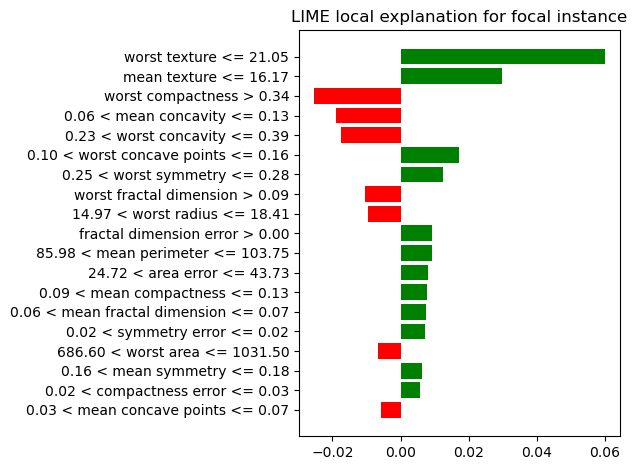

Explaining class value 1, Benign
worst texture <= 21.05                   +0.060
mean texture <= 16.17                    +0.030
worst compactness > 0.34                 -0.026
0.06 < mean concavity <= 0.13            -0.019
0.23 < worst concavity <= 0.39           -0.018
0.10 < worst concave points <= 0.16      +0.017
0.25 < worst symmetry <= 0.28            +0.012
worst fractal dimension > 0.09           -0.010
14.97 < worst radius <= 18.41            -0.010
fractal dimension error > 0.00           +0.009
85.98 < mean perimeter <= 103.75         +0.009
24.72 < area error <= 43.73              +0.008
0.09 < mean compactness <= 0.13          +0.008
0.06 < mean fractal dimension <= 0.07    +0.007
0.02 < symmetry error <= 0.02            +0.007
686.60 < worst area <= 1031.50           -0.007
0.16 < mean symmetry <= 0.18             +0.006
0.02 < compactness error <= 0.03         +0.006
0.03 < mean concave points <= 0.07       -0.006


In [ ]:
# Classes aligned to the model
classes = model_bc.classes_
class_names = [str(c) for c in list(model_bc.classes_)]

# Define an explainer
lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=class_names,
    mode="classification",
    discretize_continuous=True,
)

# Get the focus instance data
i = focus_instance_bc.index[0]
xi = focus_instance_bc.loc[i].values
print(f"Explaining focal instance with true class, Benign")
print(f"Predicted class: {model_bc.predict([xi])[0]}")
print(f"Predicted probabilities:")
for cls, prob in zip(classes, model_bc.predict_proba([xi])[0]):
    print(f"  Class {cls}: {prob:.4f}")


# Explain the instance
lime_exp = lime_explainer.explain_instance(
    xi, model_bc.predict_proba, num_features=19, top_labels=1
)

label_idx = 1  # Predicted class index

fig = lime_exp.as_pyplot_figure(label=label_idx)
plt.title(f"LIME local explanation for focal instance")
plt.tight_layout()
plt.show()

print(f"Explaining class value {label_idx}, Benign")
for feat, w in lime_exp.as_list(label=label_idx):
    print(f"{feat:40s} {w:+.3f}")

### 5. Model Decision Defence

To reiterate what we're doing, a RandomForest classification model trained on the Wisconsin Breast Cancer Dataset with 30 features from digitized images of fine needle aspirates of breast masses. These features are used to predict that the tumor from which the features were collected are either malignant or benign.

Generally, and medically, the factors that contribute to a malignant prediction are:
- benign tumors tend to be smaller in size, more uniform, less irregular, smoother, more heterogeneous texture, less errors (more uniform cell population).
- malignant tumors tend to be the opposite, larger, less uniform, more irregular, more uniform texture, higher errors.
Worst in the feature names generally mean the largest value across the sample cells and normally the larger ones tend to be malignant.
Higher concavity and concave points of the nuclei are irregular and tend to indicate a malignant tumor and vice versa for benign tumor.

I'll look at output data from the analysis to evaluate the model's prediction and defend it as being the right decision. The SHAP Cumulative Force Plot shows a global summary of the model's decision making using the test data. It shows that the model is confidently classifying two clusters of instances, one group strongly positive, one group strongly negative, and illustrates how cumulative feature contributions push predictions up (red) or down (blue). Instances with higher mean area, worst concavity, worst radius, mean concave point, worst perimeters, worst area, worst concave points were pushed towards class 0 (malignant). Instances with lower values of the same features were pushed towards class 1 (benign). Thus, on the global level, the model's predictions are in line with medical diagnosis.

The feature importance information gathered and ploted from the RandomForest model also indicates a high top 15 importance for worst area, worst concave points, mean concave points, worst radius, mean concavity, worst perimeter, mean perimeter, mean radius, mean area, worst concavity, area error, worst texture, worst compactness, radius error and mean compactness. These align with the domain expectation and the SHAP Force Plot results.

Now for the focus instance, patient X, I'll look at the result from the SHAP and LIME local explanations. From the SHAP local bar plot, the instance was pushed toward the positive class (benign) mostly by these features:
worst texture (20.86) by +0.05, mean concavity (0.078) by +0.04, worst area (812.4) by +0.03, worst radius (16.57) by +0.03, mean perimeter (90.43) by +0.02, mean texture (15.79) by +0.02, mean area (584.1) by +0.02, worst concave points (0.138) by +0.02, (minor positives from other features sum to +0.03)

There’s a small counter-signal, worst perimeter (110.3), by −0.02, but not enough to offset those positives.

The LIME explanation also supports the same story in rule form around this instance:         
- Strong positive rules such as “worst texture ≤ 21.05”, “mean texture ≤ 16.17”, and “0.10 < worst concave points ≤ 0.16” are true for the focus instance with the lower values and push toward the positive class, matching SHAP.        
- Some negative rules (e.g., involving compactness or fractal dimension thresholds) provide small offsets, echoing SHAP’s results.        

Since the different methods (SHAP and LIME) point in the same directions for the same features, it is a good robustness check for the explanations.

In conclusion:      
- The model predicted the positive class largely because low texture (worst/mean) and smaller/regular shape measures (concavity, concave points, area, radius) jointly increased the score, and in this feature space reduce the risk of a cancerous tumor. The relative values of the features can be seen from the distribution plots.       
- A few features (e.g., worst perimeter) pulled the score down slightly, but their effects were small relative to the positives.        
- This rationale is consistent with the global model behavior (feature importances), the distribution of values in the data, the local SHAP explanations, the global SHAP results and the independent local surrogate (LIME).         
Thus, at the time of the diagnosis by this model, all indications are that the tumor for person X was benign. At the later time when they had malignant tumor diagnosis, the tumor must have changed very much.